# ETL-Project

In [1]:
# Import dependencies

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import requests
import json
import numpy as np
import requests
import pymongo
from splinter import Browser
from flask import Flask, render_template, redirect
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
from config import sql
from pprint import pprint
from sqlalchemy import create_engine

In [2]:
# Read the csv file
netflix_csv = "netflix_titles.csv"
netflix_df = pd.read_csv(netflix_csv)

# Preview csv
netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [3]:
# Checking null values

check_null = netflix_df.isnull().sum()
print (check_null)

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64


In [4]:
# Drop the data where had na in date_added or rating

netflix_df = netflix_df.dropna(subset=['date_added', 'rating'])


In [5]:
# Extract the Year from date_added column - year_added to match up with release_year

netflix_df['date_added'] = pd.to_datetime(netflix_df['date_added'])
netflix_df['added_year'] = netflix_df['date_added'].dt.year

# Preview the DataFrame
netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,added_year
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020


In [6]:
# Filter the data to only Movies in type column
netflix_df = netflix_df.loc[(netflix_df["type"] == "Movie")]

# Drop the show_id, type & date_added columns
netflix_df = netflix_df.drop(columns=["show_id", "type", "date_added"]).reset_index(drop=True)

# Preview the DataFrame
netflix_df.head()


,title,director,cast,country,release_year,rating,duration,listed_in,description,added_year
0,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016
1,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018
2,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017
3,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020
4,122,Yasir Al Yasiri,"Amina Khalil, Ahmed Dawood, Tarek Lotfy, Ahmed...",Egypt,2019,TV-MA,95 min,"Horror Movies, International Movies","After an awful accident, a couple admitted to ...",2020


### Rotten Tomatoes Web Scrape

In [ ]:
# Set up Splinter
executable_path = {'executable_path': ChromeDriverManager().install()}
browser = Browser('chrome', **executable_path, headless=False)
# Visit website
url = "https://www.rottentomatoes.com/browse/dvd-streaming-all"
browser.visit(url)

### IMDB Web Scrape

### Loading into PostgreSQL

### Data Visualisation

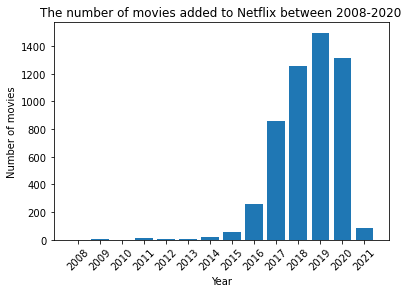

In [36]:
# Numnber of Movies added in the past years

movie_added = pd.DataFrame(netflix_df.groupby(['added_year'])['title'].count()).reset_index()

# Plot the number of movies added in the past years

x_axis = movie_added["added_year"].unique()
plt.bar(x_axis, movie_added["title"], align="center")

plt.title("The number of movies added to Netflix between 2008-2020")
plt.xlabel("Year")
plt.ylabel("Number of movies")

plt.xticks(movie_added["added_year"], rotation=45)

plt.show()